[120]Magna Graecia\
Sergio Enrico Pisoni 132855\
Sofia Papaioannou 132898\
Lefteris Verouchis 132873

# DATA PROCESSING FOR XGB TRAINED ON EVERY DAY DISTANCE

In [18]:
import pandas as pd 
import xgboost as xgb
from xgboost import plot_importance
import numpy as np
import geopandas as gpd 
from calendar import monthrange
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from shapely.ops import nearest_points

import matplotlib.pyplot as plt 
from sklearn.inspection import PartialDependenceDisplay
import shap

In [2]:
ports = pd.read_csv('ports.csv', sep ='|')
# Clean port data
ports = ports.drop(columns=['name', 'portLocation', 'UN_LOCODE', 'countryName', 'ISO'], errors='ignore')
# Rename latitude and longitude to distinguish them
ports = ports.rename(columns={
    'latitude': 'port_latitude',
    'longitude': 'port_longitude'
})

def preprocess(df):
    # Replacing default with Nan bacause too close to valid values, eliminate non valid values
    df['cog'] = df['cog'].replace(360, np.nan)
    df = df[(df['cog'] <= 360) | (df['cog'].isna())]

    # Replacing default with Nan bacause too close to valid values
    df['sog'] = df['sog'].replace(1023, np.nan)

    # Replacing default with Nan bacause too close to valid values
    # Changing uncertain values to bigger number to be further away from sample pool
    # Adding uncertainty flag
    df['rot'] = df['rot'].replace(128, np.nan)
    df['rot'] = df['rot'].replace({127: 200, -127: -200})
    df['uncertain_rot'] = np.where(df['rot'].isin([200, -200]), 1, 0)

    # Replacing default value with NaN to not get taken in consideration by regression
    df['heading'] = df['heading'].replace(511, np.nan)

    # Adding a "is moored?" flag
    df['isMoored'] = (df['navstat'] == 5).astype(int)   

    # Time Handling 
    df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.tz_localize('UTC')
    # Standardize eta
    df['etaRaw'] = df['etaRaw'].fillna(0)
    df['etaRaw'] = df['etaRaw'].apply(lambda x: f"{2024}-{x}")
    df['etaRaw'] = pd.to_datetime(df['etaRaw'], errors='coerce').dt.tz_localize('UTC')
    df.rename(columns={'etaRaw': 'etaStd'}, inplace=True)
    # Handle first month of the years ETA year to be 2023
    df['etaStd'] = df.apply(lambda row: row['etaStd'].replace(year=row['etaStd'].year - 1)
                            if row['etaStd'].month in [11, 12] and row['time'].month in [1, 2] 
                            else row['etaStd'], axis=1) 
    

    # FEATURE ENGINEERING
    # Get day of the week 
    df['dayofweek'] = df['time'].dt.dayofweek
    df['eta_dayoftheweek'] = df['etaStd'].dt.dayofweek 
    # Converts time and eta to seconds and add difference between the two
    df['time_seq'] = df['time'].astype(int) / 10**9  
    df['eta_seq'] = df['etaStd'].astype(int) / 10**9 
    df['estimated_time_left'] = df['time_seq'] - df['eta_seq']
    # Add port coordinates
    df = pd.merge(df, ports, on='portId', how='left')
    # Add a three days rolling average for the AIS data 
    df['sog_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['sog'].mean())
    df['cog_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['cog'].mean())
    df['rot_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['rot'].mean())
    df['heading_mean'] = df.groupby('vesselId', group_keys=False).apply(
    lambda x: x.sort_values('time').rolling('3D', on='time')['heading'].mean())
    
    return df

In [3]:
def make_training_set(df, steps):
    df_copy = df.copy()
    df_copy.sort_values(by=['vesselId', 'time'], inplace=True)
    
    # FEATURE ENGINEERING
    # Vessels last collenction data
    df_copy['latitude_lag'] = df_copy.groupby('vesselId')['latitude'].shift(steps)
    df_copy['longitude_lag'] = df_copy.groupby('vesselId')['longitude'].shift(steps)
    df_copy['port_longitude_lag'] = df_copy.groupby('vesselId')['port_longitude'].shift(steps)
    df_copy['port_latitude_lag'] = df_copy.groupby('vesselId')['port_latitude'].shift(steps)
    df_copy['isMoored_lag'] = df_copy.groupby('vesselId')['isMoored'].shift(steps)
    df_copy['sog_lag'] = df_copy.groupby('vesselId')['sog'].shift(steps)
    df_copy['sog_mean_lag'] = df_copy.groupby('vesselId')['sog_mean'].shift(steps)
    df_copy['cog_lag'] = df_copy.groupby('vesselId')['cog'].shift(steps)
    df_copy['cog_mean_lag'] = df_copy.groupby('vesselId')['cog_mean'].shift(steps)     
    df_copy['rot_lag'] = df_copy.groupby('vesselId')['rot'].shift(steps) 
    df_copy['rot_mean_lag'] = df_copy.groupby('vesselId')['rot_mean'].shift(steps)
    df_copy['uncertain_rot_lag'] = df_copy.groupby('vesselId')['uncertain_rot'].shift(steps) 
    df_copy['heading_lag'] = df_copy.groupby('vesselId')['heading'].shift(steps)
    df_copy['heading_mean_lag'] = df_copy.groupby('vesselId')['heading_mean'].shift(steps)  
    df_copy['dayofweek_lag'] = df_copy.groupby('vesselId')['dayofweek'].shift(steps)
    # Time since last data collection
    df_copy['time_diff'] = df_copy.groupby('vesselId')['time'].diff(steps)
    df_copy['time_diff_seconds'] = df_copy['time_diff'].dt.total_seconds()
    # Time to eta
    df_copy['estimated_time_left_lag'] = df_copy.groupby('vesselId')['estimated_time_left'].shift(steps)
    df_copy.dropna(subset=['time_diff'], inplace=True)
    return df_copy

# TRAIN ON DIFFERENT TIME HORIZONS

## Process train

In [4]:
# Load train data
known_positions = pd.read_csv('ais_train.csv', sep ='|')  # Replace with your dataset
test = pd.read_csv('ais_test.csv', sep =',')
# Preprocess train
known_positions = preprocess(known_positions)
train = known_positions.copy()
# Create training sets with variable time difference
time_intervals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 44, 48, 52, 56, 60, 64, 68, 72] #until 88hrs intervals
train_sets = {}
for interval in time_intervals:
    train_sets[f'train{interval}'] = make_training_set(train, interval)

train = pd.concat(list(train_sets.values()), ignore_index=True)


In [5]:
train['navstat'] = pd.Categorical(train['navstat']).codes
train['portId'] = pd.Categorical(train['portId']).codes
# Encoding test and train vesselID with the same encoder 
unique_vessel_ids = pd.concat([known_positions['vesselId'], test['vesselId']]).unique()
vessel_encoder = LabelEncoder()
vessel_encoder.fit(unique_vessel_ids)
# Transform the vesselId column in train
train['vesselId'] = vessel_encoder.transform(train['vesselId'])

# Clean missing data
train = train.dropna(subset=['latitude', 'longitude', 'time'])

In [6]:
# Prepare training and evalutaion set
X = train[[
    'vesselId', #try
    'latitude_lag',
    'longitude_lag',
    'port_latitude_lag',
    'port_longitude_lag',
    'isMoored_lag',
    'sog_lag',
    'sog_mean_lag',
    'cog_lag',
    'cog_mean_lag',
    'rot_lag',
    'rot_mean_lag',
    'uncertain_rot_lag',
    'heading_lag',
    'heading_mean_lag',
    'dayofweek_lag',
    'time_diff_seconds',
    'estimated_time_left_lag',
]]
y = train[['latitude', 'longitude']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X_train.apply(pd.to_numeric, errors='coerce') 

In [7]:
base_model = xgb.XGBRegressor(
    learning_rate=0.24196263261990883,
    max_depth=9,
    min_child_weight=1,
    n_estimators=185,
    subsample=0.9136916108674354,
    random_state=42
)
model = MultiOutputRegressor(base_model)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred_val = model.predict(X_val)
# Evaluate model
mae = mean_absolute_error(y_val, y_pred_val)
mae

0.7712327947696873

In [8]:
test['time'] = pd.to_datetime(test['time'], errors='coerce').dt.tz_localize('UTC')
test['vesselId'] = vessel_encoder.transform(test['vesselId'])
known_positions['vesselId'] = vessel_encoder.transform(known_positions['vesselId'])

In [9]:
def prepare_prediction_data(test_df, known_positions):
    # Get last known position for each vessel before the test time
    predictions_data = []
    
    # Group by vessel ID to avoid repeated processing
    vessel_histories = dict(tuple(known_positions.groupby('vesselId')))
    
    for _, row in test_df.iterrows():
        vessel_history = vessel_histories[row['vesselId']]
        # Get last position before test time
        last_detection = vessel_history[vessel_history['time'] < row['time']].iloc[-1]
        
        predictions_data.append({
            'vesselId': last_detection['vesselId'],
            'latitude_lag': last_detection['latitude'],
            'longitude_lag': last_detection['longitude'],
            'port_latitude_lag': last_detection['port_latitude'],
            'port_longitude_lag': last_detection['port_longitude'],
            'isMoored_lag': last_detection['isMoored'],
            'sog_lag': last_detection['sog'],
            'sog_mean_lag': last_detection['sog_mean'],
            'cog_lag': last_detection['cog'],
            'cog_mean_lag': last_detection['cog_mean'],
            'rot_lag': last_detection['rot'],
            'rot_mean_lag': last_detection['rot_mean'],
            'uncertain_rot_lag': last_detection['uncertain_rot'],
            'heading_lag': last_detection['heading'],
            'heading_mean_lag': last_detection['heading_mean'],
            'dayofweek_lag': last_detection['dayofweek'],
            'time_diff_seconds': (pd.to_datetime(row['time']) - last_detection['time']).total_seconds(),
            'estimated_time_left_lag': last_detection['estimated_time_left'],
        })
    
    return pd.DataFrame(predictions_data)

# Prepare prediction data
input_df = prepare_prediction_data(test, known_positions)
# Make predictions for all rows at once
predictions = model.predict(input_df)
# Create results DataFrame
results = pd.DataFrame({
    'ID': test.index,
    'longitude_predicted': predictions[:, 1],
    'latitude_predicted': predictions[:, 0]
})

In [10]:
results.to_csv('no_postproc_1.csv', index=False)

## Post processing
Move all predictions to sea

In [11]:
test = pd.read_csv('ais_test.csv', sep=',') # reset test df
test = test.drop(columns=['scaling_factor']) 
merged = pd.merge(results, test, on='ID', how='left')
merged['time'] = pd.to_datetime(merged['time'])

In [12]:
# Load ocean and land shape files
land_world = gpd.read_file('ne_10m_land/ne_10m_land.shp').to_crs(4326)
ocean_world = gpd.read_file('ne_10m_ocean/ne_10m_ocean.shp').to_crs(4326)
# Make Geo Data Frame
gdf = gpd.GeoDataFrame(merged, geometry=gpd.points_from_xy(merged['longitude_predicted'], merged['latitude_predicted'], crs="EPSG:4326"))
# Check if point is on land
points_on_land = gpd.sjoin(gdf, land_world, how="inner", predicate="within")

In [13]:
# Get closest points in sea
closest_longitudes = []
closest_latitudes = []
for _, row in points_on_land.iterrows():
    closest_point, _ = nearest_points(ocean_world['geometry'], row['geometry'])
    closest_longitudes.append(closest_point.x)
    closest_latitudes.append(closest_point.y)
points_on_land['closest_longitude'] = closest_longitudes
points_on_land['closest_latitude'] = closest_latitudes

In [14]:
# Update predictions
gdf.loc[points_on_land.index, 'longitude_predicted'] = points_on_land['closest_longitude'].astype(float)
gdf.loc[points_on_land.index, 'latitude_predicted'] = points_on_land['closest_latitude'].astype(float)
gdf = gdf.drop(columns=['vesselId', 'time', 'geometry'])

/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_33894/3106212199.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gdf.loc[points_on_land.index, 'longitude_predicted'] = points_on_land['closest_longitude'].astype(float)
/var/folders/_k/_j2m440s1cdcpmdx7hff9q0r0000gn/T/ipykernel_33894/3106212199.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gdf.loc[points_on_land.index, 'latitude_predicted'] = points_on_land['closest_latitude'].astype(float)


In [15]:
gdf.to_csv('result_n1.csv', index=False)

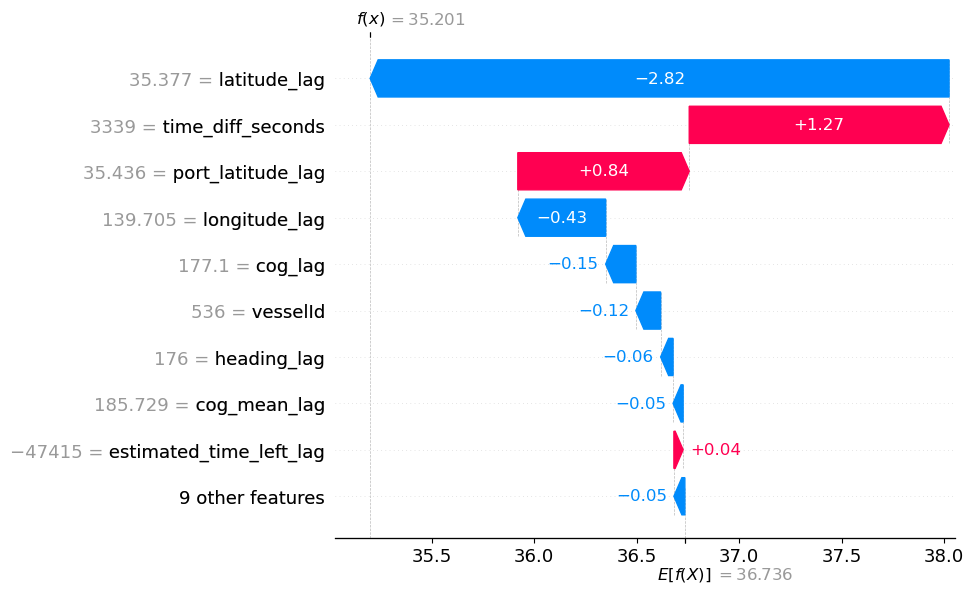

In [46]:
explainer = shap.TreeExplainer(model.estimators_[0])
# Replace this with your instance of interest
instance = X_train.iloc[[50000010]]  # Using first row as example

# Calculate SHAP values for the instance
shap_values = explainer.shap_values(instance)

# Create and save waterfall plot
plt.figure(figsize=(8, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=instance.values[0],
        feature_names=X_train.columns
    )
)
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png')
plt.close()